# Task 2 

## Data download and split

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=100)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=100)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_val = X_test[:12500]
y_val = y_test[:12500]
X_test = X_test[12500:]
y_test = y_test[12500:]

batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

## Model creation

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

def create_simple_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(SimpleRNN(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Accuracy, loss and gradient plot

Epoch [1/5], Train Loss: 0.0036, Val Loss: 0.0030, Train Accuracy: 64.3102, Val Accuracy: 64.2243
Epoch [2/5], Train Loss: 0.0022, Val Loss: 0.0032, Train Accuracy: 64.3679, Val Accuracy: 64.1886
Epoch [3/5], Train Loss: 0.0014, Val Loss: 0.0038, Train Accuracy: 64.4125, Val Accuracy: 64.2523
Epoch [4/5], Train Loss: 0.0008, Val Loss: 0.0048, Train Accuracy: 64.4882, Val Accuracy: 64.2981
Epoch [5/5], Train Loss: 0.0005, Val Loss: 0.0056, Train Accuracy: 64.4498, Val Accuracy: 64.1917


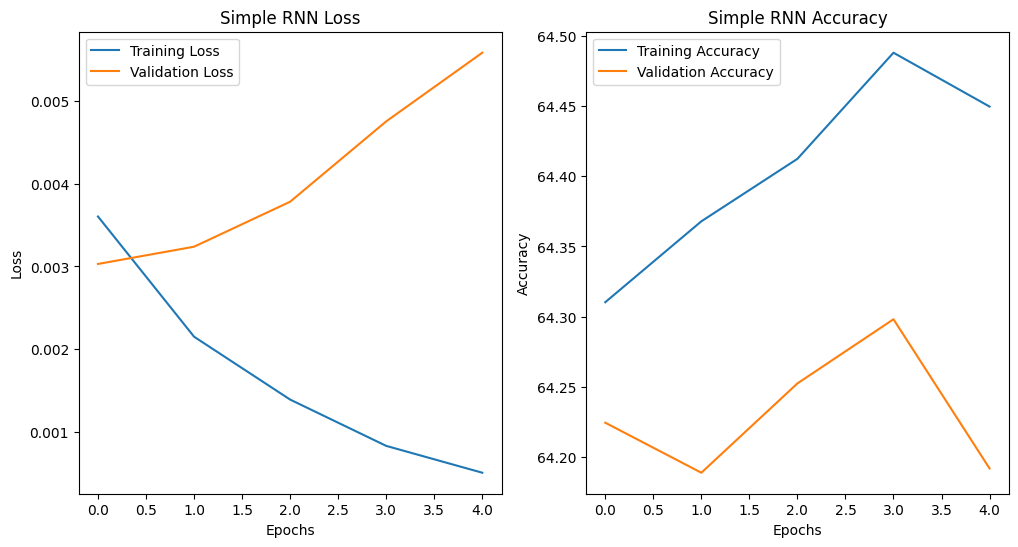

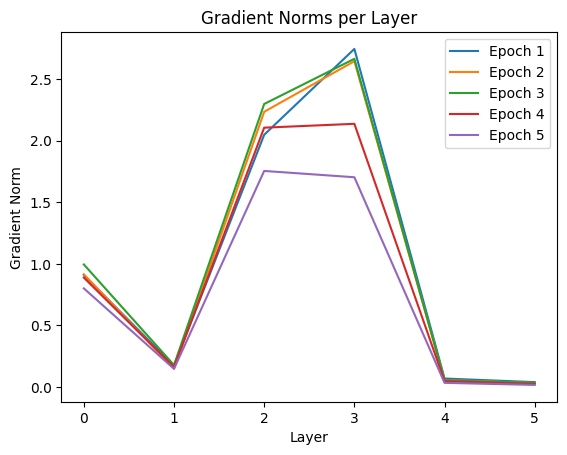

In [17]:
import matplotlib.pyplot as plt
simple_rnn_model = create_simple_rnn_model()

num_epochs = 5
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
gradient_norms = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_train_predictions = 0
    correct_val_predictions = 0
    total_train_samples = 0
    total_val_samples = 0
    epoch_gradient_norms = []

    for X_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = simple_rnn_model(X_batch, training=True)
            loss = loss_fn(y_batch, y_pred)
        gradients = tape.gradient(loss, simple_rnn_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, simple_rnn_model.trainable_variables))

        epoch_train_loss += loss.numpy()
        correct_train_predictions += np.sum((y_pred.numpy() >= 0.5) == y_batch.numpy())
        total_train_samples += y_batch.shape[0]

        batch_gradient_norms = [tf.norm(grad).numpy() for grad in gradients if grad is not None]
        epoch_gradient_norms.append(batch_gradient_norms)

    for X_batch, y_batch in val_dataset:
        y_pred = simple_rnn_model(X_batch, training=False)
        loss = loss_fn(y_batch, y_pred)
        epoch_val_loss += loss.numpy()
        correct_val_predictions += np.sum((y_pred.numpy() >= 0.5) == y_batch.numpy())
        total_val_samples += y_batch.shape[0]

    train_loss = epoch_train_loss / total_train_samples
    val_loss = epoch_val_loss / total_val_samples
    train_accuracy = correct_train_predictions / total_train_samples
    val_accuracy = correct_val_predictions / total_val_samples

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    gradient_norms.append(np.mean(epoch_gradient_norms, axis=0))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Simple RNN Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Simple RNN Accuracy')
plt.show()

plt.figure()
for epoch, norms in enumerate(gradient_norms):
    plt.plot(norms, label=f'Epoch {epoch + 1}')
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms per Layer')
plt.legend()

# Task 3

## LSTM

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [19]:
lstm_model = create_lstm_model()

num_epochs = 5
lstm_history = lstm_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

test_loss, test_accuracy = lstm_model.evaluate(test_dataset)

print(f'LSTM Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/5
196/196 [==============================] - 47s 233ms/step - loss: 0.4363 - accuracy: 0.7848 - val_loss: 0.3487 - val_accuracy: 0.8450
Epoch 2/5
196/196 [==============================] - 25s 128ms/step - loss: 0.2570 - accuracy: 0.8962 - val_loss: 0.3767 - val_accuracy: 0.8350
Epoch 3/5
196/196 [==============================] - 31s 157ms/step - loss: 0.2091 - accuracy: 0.9208 - val_loss: 0.4269 - val_accuracy: 0.8361
Epoch 4/5
196/196 [==============================] - 31s 158ms/step - loss: 0.1732 - accuracy: 0.9324 - val_loss: 0.4378 - val_accuracy: 0.8394
Epoch 5/5
98/98 [==============================] - 5s 51ms/step - loss: 0.4309 - accuracy: 0.8378
LSTM Test Loss: 0.4309, Test Accuracy: 0.8378


## GRU

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

def create_gru_model():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
gru_model = create_gru_model()
gru_history = gru_model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)
test_loss, test_accuracy = gru_model.evaluate(test_dataset)

print(f'GRU Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/5
196/196 [==============================] - 24s 114ms/step - loss: 0.4514 - accuracy: 0.7684 - val_loss: 0.3612 - val_accuracy: 0.8419
Epoch 2/5
196/196 [==============================] - 20s 102ms/step - loss: 0.2690 - accuracy: 0.8908 - val_loss: 0.4437 - val_accuracy: 0.8302
Epoch 3/5
196/196 [==============================] - 20s 105ms/step - loss: 0.2215 - accuracy: 0.9138 - val_loss: 0.4114 - val_accuracy: 0.8294
Epoch 4/5
196/196 [==============================] - 21s 107ms/step - loss: 0.1848 - accuracy: 0.9289 - val_loss: 0.4273 - val_accuracy: 0.8328
Epoch 5/5
98/98 [==============================] - 3s 28ms/step - loss: 0.4367 - accuracy: 0.8260
GRU Test Loss: 0.4367, Test Accuracy: 0.8260


## LSTM and GRU comperason

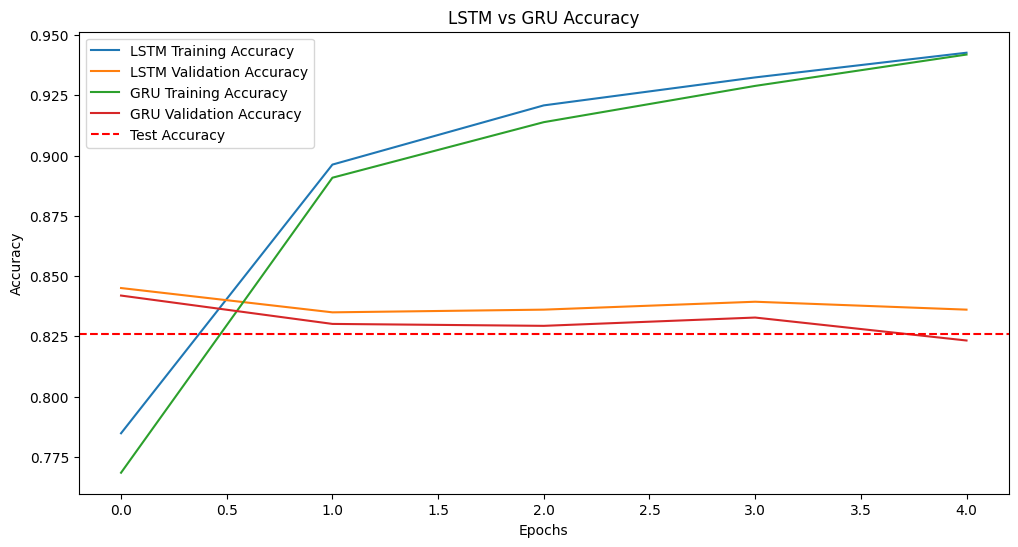

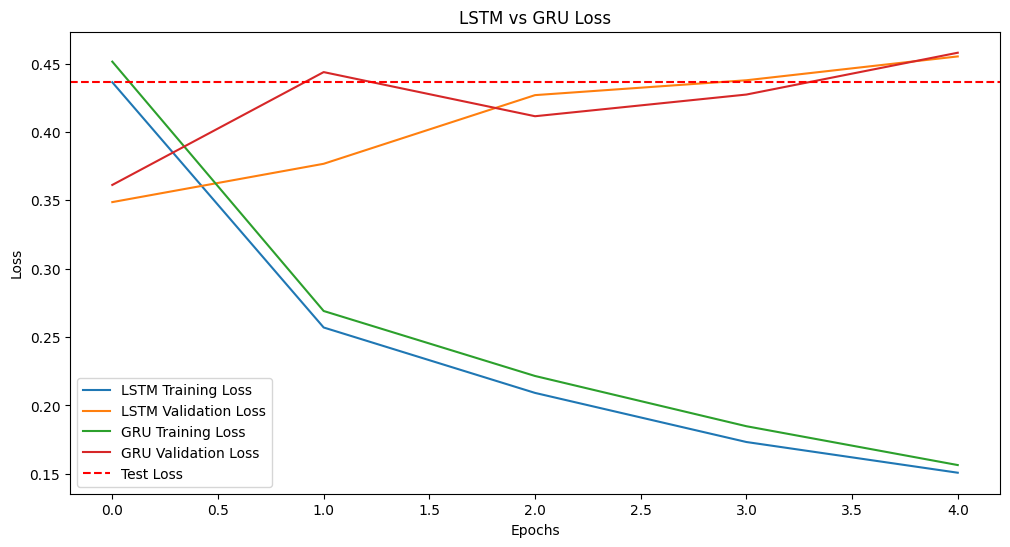

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['accuracy'], label='LSTM Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(gru_history.history['accuracy'], label='GRU Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('LSTM vs GRU Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM vs GRU Loss')
plt.show()